# Minimize experiments

## Minimize the Rosenbrock function

$$ f(x) = \sum_{d=1:D-1} 100 (x_{d+1} - x_d^a)^2 + (1-x_d)^2 $$

In [1]:
from minimize import line_search, kalman_filter_smoother
from helpers import plot_linesearch
import matplotlib.pyplot as plt

import os
from datetime import datetime

In [2]:
import autograd.numpy as np
from autograd import grad


def convert_to_1d_objective(f, x, d):
    """
    Converts a multivariate objective function f to the univariate function
    
        g(a) = f(x + a * d),
        
    handling the derivatives as well.
    """
    
    def g(a):
        
        ga, dfa = f(x + a * d)
        
        dga = np.dot(dfa, d)
        
        return np.array([[ga, dga]])
    
    return g
    

def rosenbrock(x, a):
    
    def f(x, a):
        return np.sum(100 * (x[1:] - x[:-1] ** a) ** 2 + (1 - x[:-1]) ** 2)
    
    df = grad(f, argnum=0)
    
    fx = f(x, a)
    dfx = df(x, a)
    
    return fx, dfx

In [3]:
x = np.ones(shape=(2,))

print(rosenbrock(x, 2))

standard_rosenbrock = lambda x : rosenbrock(x, a=2)

linesearch_objective = convert_to_1d_objective(standard_rosenbrock, x, d=x)

print(linesearch_objective(x))

(0.0, array([0., 0.]))
[[ 401. 1202.]]


In [4]:
def conjugate_gradients(objective, x0, c1, c2, wp_thresh, save_path):
    
    t0 = 0.
    t_guess = np.array([1.])
    num_dim = x0.shape[0]
            
    f, df = objective(x0)
    
    d = - df
    g = df
    diff = None
    
    x = x0
    xhist = [x]
    fhist = [f]
    
    names = ['t', 'y', 'wp_probs', 'ms', 'Vs', 'iVC', 'post_probs']
    os.mkdir(f'{os.getcwd()}/{save_path}')
    
    print(save_path)
    
    for i in range(10): # 20 * x.shape[0]
        
        linesearch_objective = convert_to_1d_objective(objective, x, d)
        
        # Create y0 array
        y0 = np.array([[f, np.dot(df, d)]])
        
        if not (diff is None): t_guess = np.abs(diff / y0[0, 1])
            
        print(t_guess)
        
        t, y, wp_probs, ms, Vs, iVC, post_probs = line_search(objective=linesearch_objective,
                                                              c1=c1,
                                                              c2=c2,
                                                              wp_thresh=wp_thresh,
                                                              t0=t0,
                                                              y0=y0,
                                                              t_guess=t_guess)
            
        os.mkdir(f'{os.getcwd()}/{save_path}/{str(i).zfill(5)}')
        
        for name, array in zip(names, [t, y, wp_probs, ms, Vs, iVC, post_probs]):
            np.save(f'{os.getcwd()}/{save_path}/{str(i).zfill(5)}/{name}.npy', array)
            
        plot_linesearch(c1=c1,
                        c2=c2,
                        t_data=t,
                        ms=ms,
                        Vs=Vs,
                        iVC=iVC,
                        post_probs=post_probs,
                        wp_probs=wp_probs,
                        x=None,
                        y=y)
        
        idx_best = np.argmax(wp_probs)
        alpha = float(t[idx_best+1])
        
        print(f'step {i:3d} objective {fhist[-1]} alpha {alpha}')
        
        # Update x
        x = x + alpha * d
        f_, df_ = objective(x)
        
        # Update d and df
        beta = np.dot(df_, (df_ - df)) / np.dot(df, df)
        
        if False: # i > 0 and i % x.shape[0] == 0
            d = - df_
        else:
            d = - df_ + beta * d
            
        # Ensure searching in direction of decreasing objective
        if np.dot(d, df_) > 0.:
            d = - d
            
        diff = np.array([f_ - f])
        
        f = f_
        df = df_
        
        xhist.append(x)
        fhist.append(f)
        
    return np.array(xhist)

2020-11-27--19-17-26
[1.]


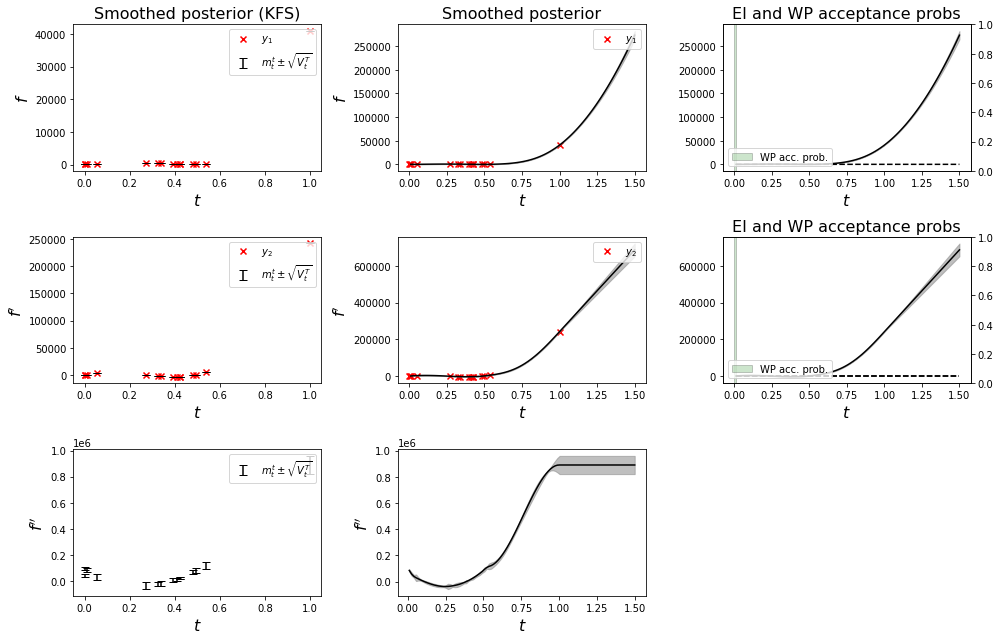

step   0 objective 99.0 alpha 0.00420089132290078
[0.17479107]


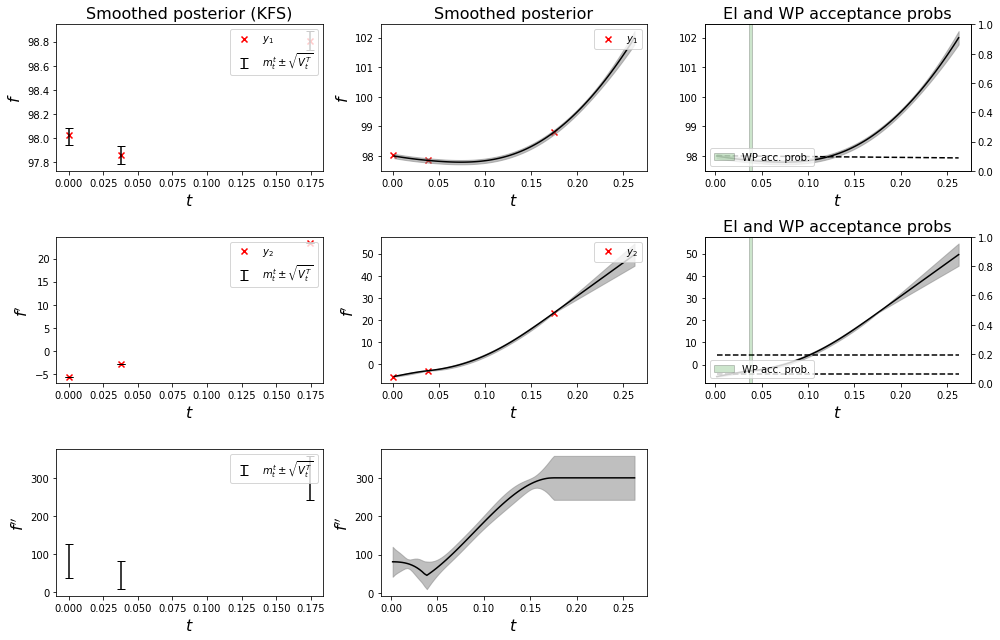

step   1 objective 98.02364190236965 alpha 0.03797353004033592
[0.02282978]


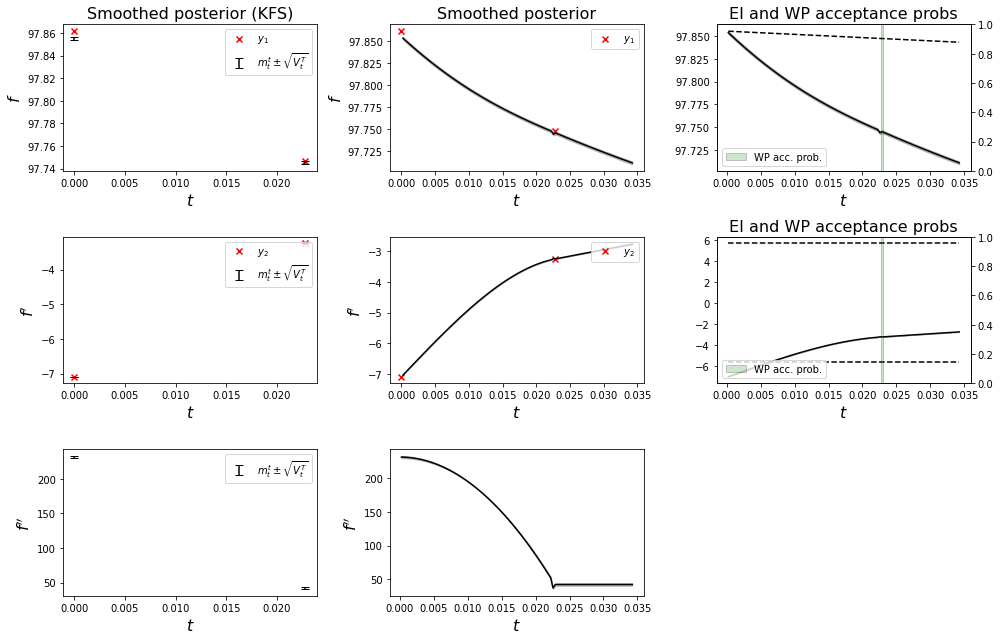

step   2 objective 97.86172737097816 alpha 0.022829784411002748
[0.00509209]


/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:119: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:120: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:166: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:119: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:120: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,


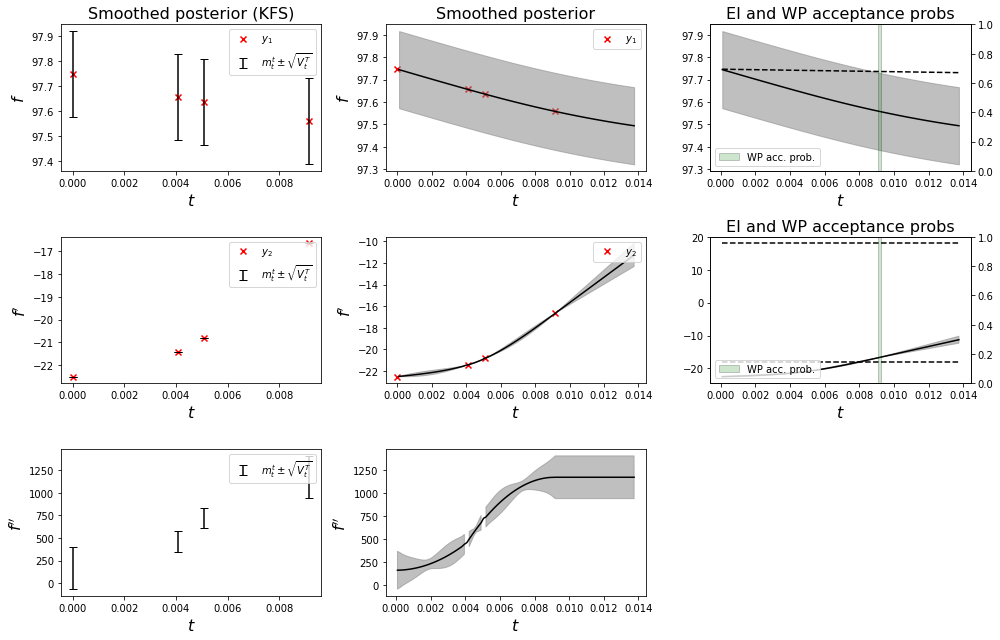

step   3 objective 97.74709191089023 alpha 0.009165768682048924
[0.01451201]


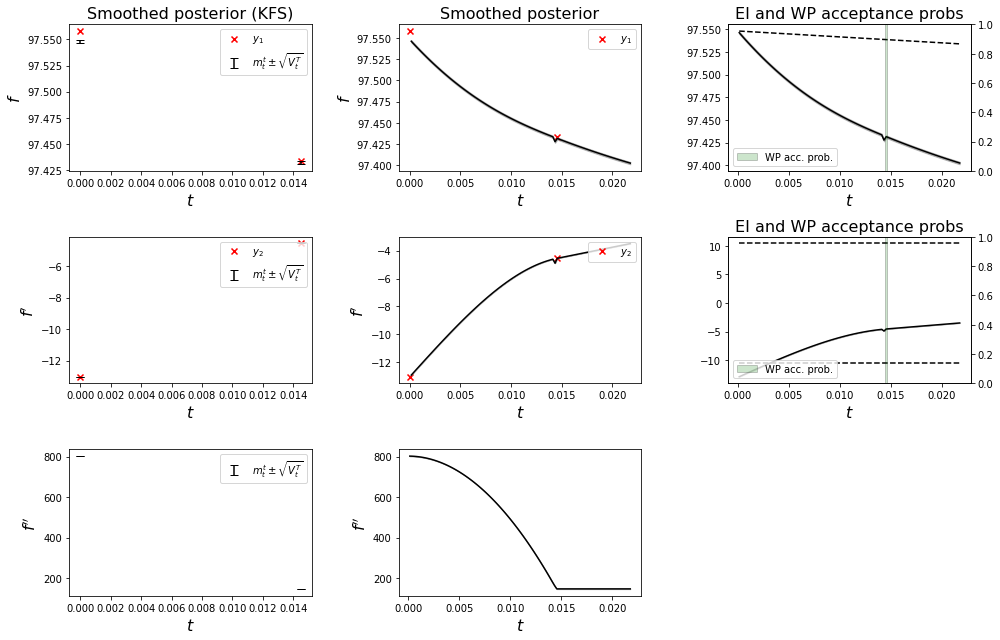

step   4 objective 97.55799084615012 alpha 0.014512005946424376
[0.00531437]


/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:119: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:120: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:166: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:119: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:120: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,


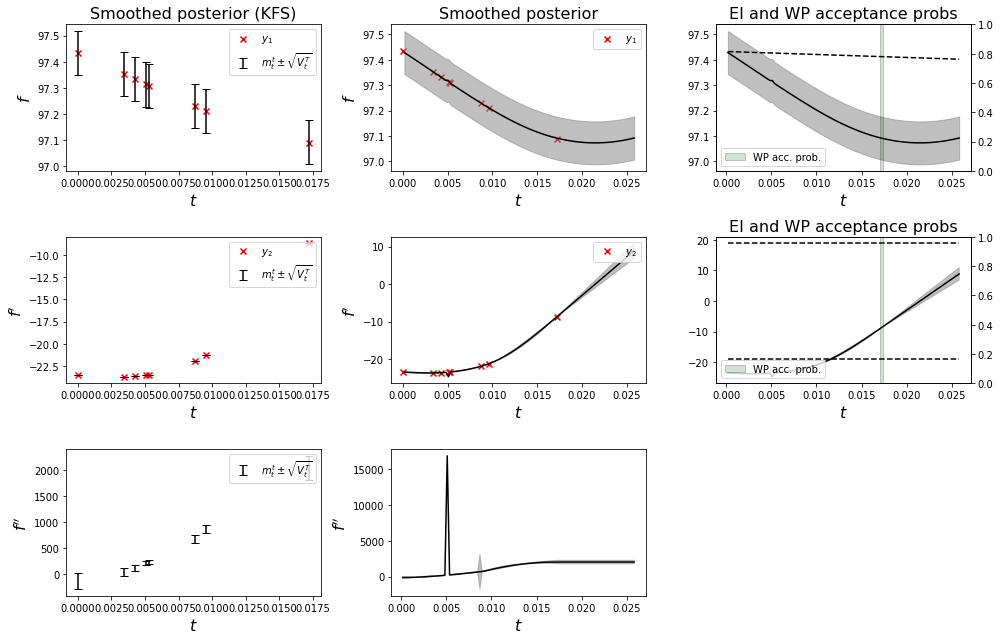

step   5 objective 97.43324911275195 alpha 0.017218574521782753
[0.00524642]


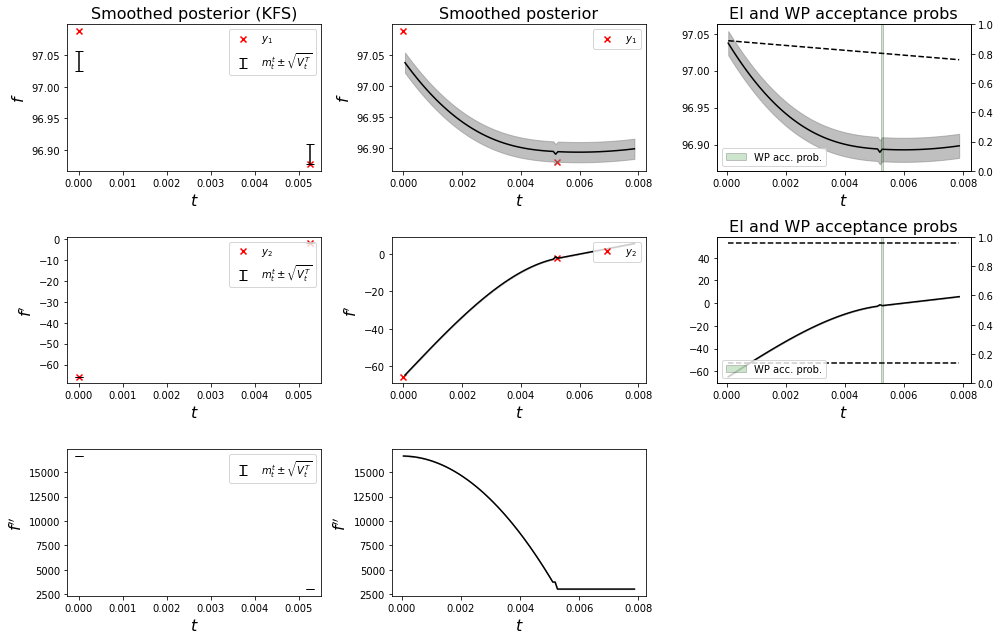

step   6 objective 97.08829604933922 alpha 0.005246424993213837
[0.00186345]


/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:119: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:120: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:166: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:119: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:120: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,


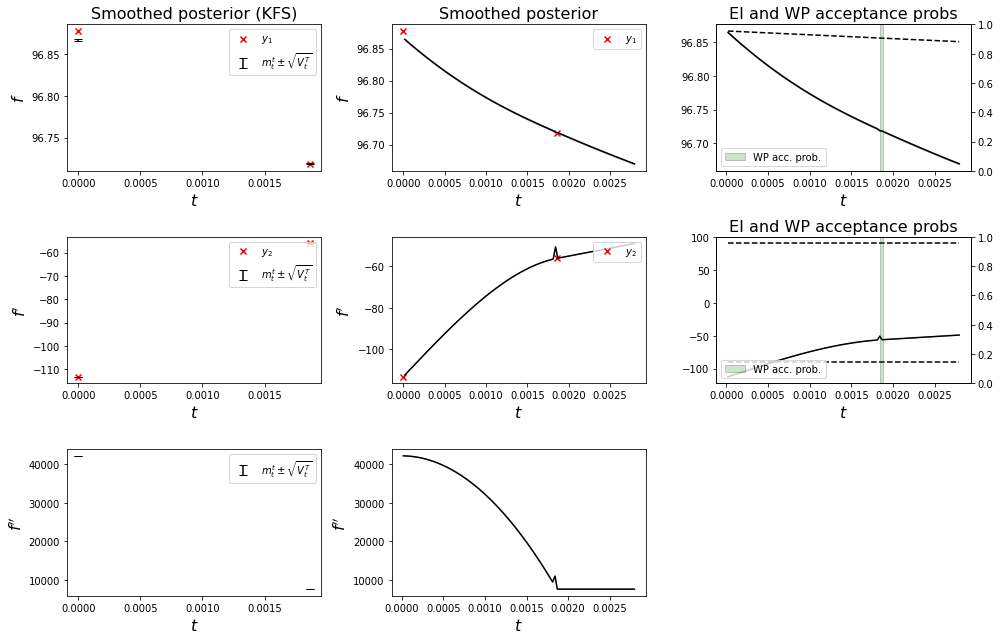

step   7 objective 96.87736894731185 alpha 0.0018634542189469487
[0.00205255]


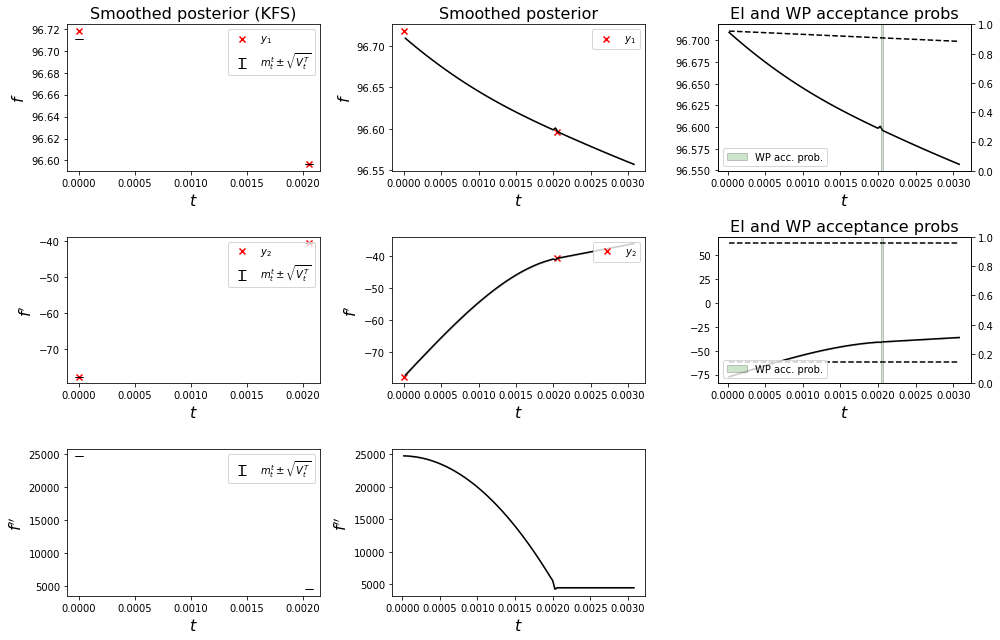

step   8 objective 96.71797722726836 alpha 0.0020525462130361514
[0.00668738]


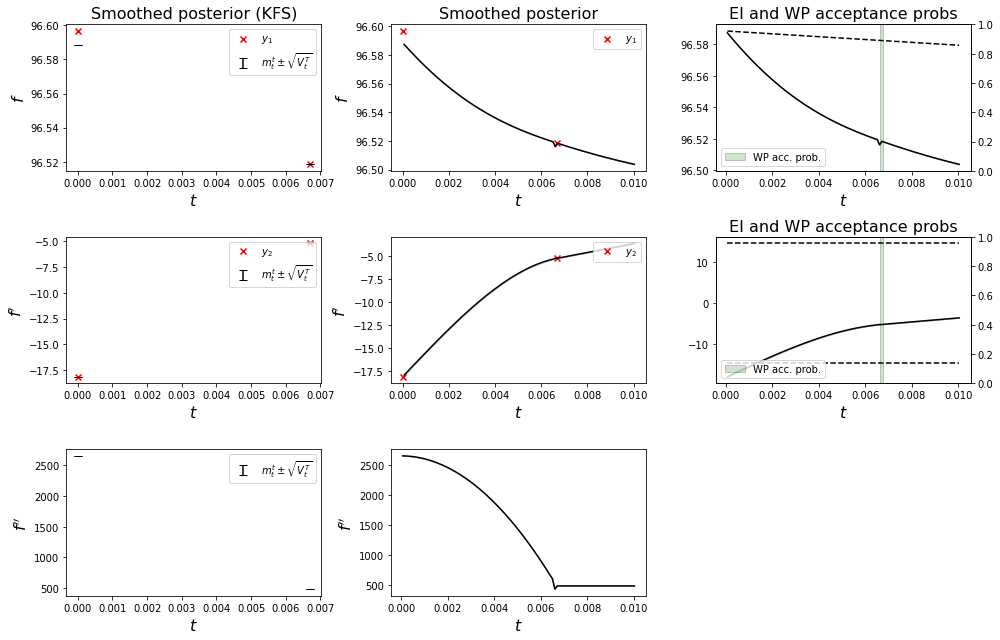

step   9 objective 96.59664808450216 alpha 0.006687376376054085


In [5]:
c1 = 0.05
c2 = 0.8
wp_thresh = 0.95

ndim = 100
x0 = np.zeros(shape=(ndim,))

standard_rosenbrock = lambda x : rosenbrock(x, a=2)

save_path = datetime.now().strftime('%Y-%m-%d--%H-%M-%S')

xhist = conjugate_gradients(objective=standard_rosenbrock,
                            x0=x0,
                            c1=c1,
                            c2=c2,
                            wp_thresh=wp_thresh, 
                            save_path=save_path)

In [6]:
# plt.figure(figsize=(8, 8))

# eps = 2.

# x1, x2 = np.meshgrid(np.linspace(1. - eps, 1 + eps, 40), np.linspace(1. - eps, 1. + eps, 40))
# x = np.stack([x1, x2], axis=-1)
# x = np.reshape(x, (-1, 2))

# f = np.array([standard_rosenbrock(x_)[0] for x_ in x])
# f = np.reshape(f, (x1.shape[0], x1.shape[0]))

# plt.contourf(x1, x2, np.log(f) + 1e-6, cmap='coolwarm', alpha=0.5)
# plt.plot(xhist[:, 0], xhist[:, 1], color='black')
# plt.gca().set_aspect('equal')
# plt.xlim([1. - eps, 1. + eps])
# plt.ylim([1. - eps, 1. + eps])
# plt.show()

In [7]:
# import scipy as scp

# ndim = 10
# x0 = np.zeros(shape=(ndim,))

# standard_rosenbrock_f = lambda x : rosenbrock(x, a=10)[0]
# standard_rosenbrock_df = lambda x : rosenbrock(x, a=10)[1]

# scp.optimize.minimize(fun=standard_rosenbrock_f,
#                       x0=x0,
#                       method='CG',
#                       jac=standard_rosenbrock_df,
#                       options={'maxiter' : 1000})

# Plotting searches



[[9.97521249e-01]
 [2.47260697e-03]
 [6.12897985e-06]
 [1.51922221e-08]
 [3.76577537e-11]
 [9.33442390e-14]]


/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:119: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:120: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:165: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:166: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:119: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] - v[:, i, i] ** 0.5,
/Users/stratis/repos/random-walks/random-walks/content/misc/pls/helpers.py:120: RuntimeWarning: invalid value encountered in sqrt
  m[:, i] + v[:, i, i] ** 0.5,


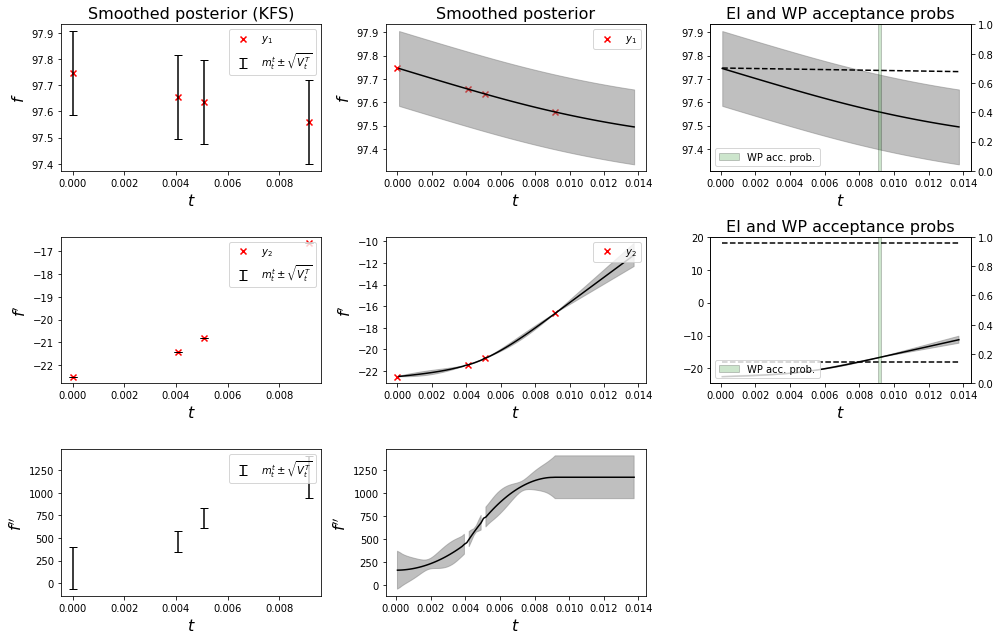

In [96]:
i = 3

names = ['t', 'y', 'wp_probs', 'ms', 'Vs', 'iVC', 'post_probs']
loaded = [np.load(f'{os.getcwd()}/{save_path}/{str(i).zfill(5)}/{name}.npy') for name in names]
t, y, wp_probs, ms, Vs, iVC, post_probs = loaded

print(post_probs)

j = 0

plot_linesearch(c1=c1,
                c2=c2,
                t_data=t,
                ms=ms[j:j+1],
                Vs=Vs[j:j+1],
                iVC=iVC[j:j+1],
                post_probs=np.ones_like(post_probs[j:j+1]),
                wp_probs=wp_probs,
                x=None,
                y=y)

[3.81710203e-13] [-38.72148274]


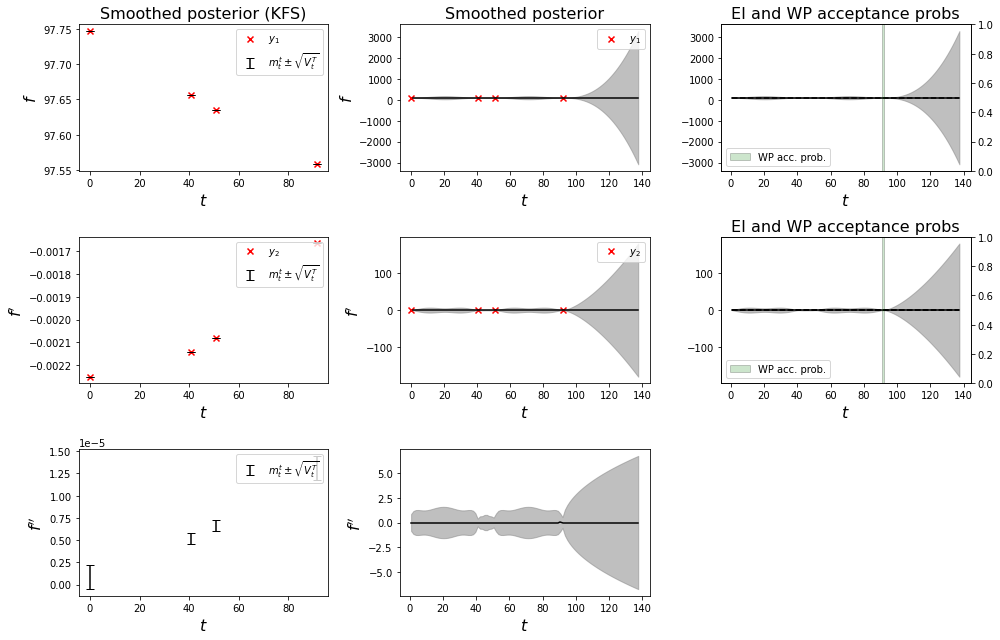

In [124]:
scale = 10000

y_ = y[:].copy()
y_[:, 1] = y_[:, 1] / scale
mf, Vf, ms, Vs, iVC, theta2, nlml = kalman_filter_smoother(scale * t, y_, log_nsr=-10)

print(theta2, nlml)

plot_linesearch(c1=c1,
                c2=c2,
                t_data=t * scale,
                ms=ms[None, :],
                Vs=Vs[None, :],
                iVC=iVC[None, :],
                post_probs=np.array([1.]),
                wp_probs=wp_probs,
                x=None,
                y=y_)

In [126]:
y_, scale * (t[1] - t[0]) * y_[0, 1]

(array([[ 9.77470919e+01, -2.25124412e-03],
        [ 9.76569067e+01, -2.14383779e-03],
        [ 9.76353694e+01, -2.08313789e-03],
        [ 9.75579908e+01, -1.66579295e-03]]),
 -0.09170836807033994)

# Notes

- Check numerical stability. Sometimes error bars seem way too large.
- Why does $f''$ seem constant?
- Fix matrix inversions - do this symbolically.